In [1]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers 
from tensorflow.keras.layers import BatchNormalization as bn
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import model_from_json
import tensorflow as tf 
import keras.backend as K

In [2]:
!pip install nibabel


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle

In [4]:
cd C:/Users/ghrceaiml1/Desktop/3D liver tumour segmentation/dataset/LITS17/

C:\Users\ghrceaiml1\Desktop\3D liver tumour segmentation\dataset\LITS17


In [5]:
img_path = glob("volume-*.nii")
mask_path = glob("segmentation-*.nii")

print("Number of images :", len(img_path))

Number of images : 98


In [6]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [7]:
img_path.sort(key=natural_keys)
mask_path.sort(key=natural_keys)

In [8]:
img_path

['volume-31.nii',
 'volume-32.nii',
 'volume-33.nii',
 'volume-34.nii',
 'volume-35.nii',
 'volume-36.nii',
 'volume-37.nii',
 'volume-38.nii',
 'volume-39.nii',
 'volume-40.nii',
 'volume-41.nii',
 'volume-42.nii',
 'volume-43.nii',
 'volume-44.nii',
 'volume-45.nii',
 'volume-46.nii',
 'volume-47.nii',
 'volume-48.nii',
 'volume-49.nii',
 'volume-50.nii',
 'volume-51.nii',
 'volume-52.nii',
 'volume-53.nii',
 'volume-54.nii',
 'volume-55.nii',
 'volume-56.nii',
 'volume-57.nii',
 'volume-58.nii',
 'volume-59.nii',
 'volume-60.nii',
 'volume-61.nii',
 'volume-62.nii',
 'volume-63.nii',
 'volume-64.nii',
 'volume-65.nii',
 'volume-66.nii',
 'volume-67.nii',
 'volume-68.nii',
 'volume-69.nii',
 'volume-70.nii',
 'volume-71.nii',
 'volume-72.nii',
 'volume-73.nii',
 'volume-74.nii',
 'volume-75.nii',
 'volume-76.nii',
 'volume-77.nii',
 'volume-78.nii',
 'volume-79.nii',
 'volume-80.nii',
 'volume-81.nii',
 'volume-82.nii',
 'volume-83.nii',
 'volume-84.nii',
 'volume-85.nii',
 'volume-8

In [9]:
patch_ratio = []

for i in range(16 + 1):
  patch_ratio.append(32 * i)
patch_ratio

[0,
 32,
 64,
 96,
 128,
 160,
 192,
 224,
 256,
 288,
 320,
 352,
 384,
 416,
 448,
 480,
 512]

In [10]:
def patch_sampling(img, mask, patch_ratio, pos_neg_ratio, threshold):
  
  temp_mask = mask
  
  temp_mask[temp_mask == 1] = 0
  temp_mask[temp_mask == 2] = 1
  
  positive_patch = []
  positive_mask = []
  
  negative_patch = []
  negative_mask = []
  
  negative_set = []
  
  
  for i in range(temp_mask.shape[2]):
    for x_bin in range(2, len(patch_ratio)):
        for y_bin in range(2, len(patch_ratio)):
          img_patch = img[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin], i]
          mask_patch = temp_mask[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin], i]
          _, count = np.unique(mask_patch, return_counts = True)
          
          if len(count) == 2:
            mask_percentage = count[1] / sum(count) * 100
          
            if threshold < mask_percentage :
              positive_patch.append(img_patch)
              positive_mask.append(mask_patch)
          
          
          elif len(count) ==1:
            
            temp_list = []
            temp_list.append(img_patch)
            temp_list.append(mask_patch)
            
            negative_set.append(temp_list)
  
  shuffle(negative_set)
  
  negative_set_to_use = negative_set[:len(positive_patch) * pos_neg_ratio]
  for negative_set in negative_set_to_use:
    negative_patch.append(negative_set[0])
    negative_mask.append(negative_set[1])
  
  negative_set_to_use = []
  
  return positive_patch, positive_mask, negative_patch, negative_mask

In [11]:
def slice_to_patch(slice, patch_ratio):
  
  slice[slice == 1] = 0
  slice[slice == 2] = 1
  
  patch_list = []
  
  for x_bin in range(2, len(patch_ratio)):
    for y_bin in range(2, len(patch_ratio)):
      patch = slice[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin]]
      patch = patch.reshape(patch.shape + (1,))
      patch_list.append(patch)
  
  return np.array(patch_list)

In [12]:
def patch_to_slice(patch, patch_ratio, input_shape, conf_threshold):
  
  slice = np.zeros((512, 512, 1))
  row_idx = 0
  col_idx = 0
  
  for i in range(len(patch)):
    
    slice[patch_ratio[row_idx]:patch_ratio[row_idx + 2], patch_ratio[col_idx]:patch_ratio[col_idx + 2]][patch[i] > conf_threshold] = 1
    
    col_idx += 1
    
    if i != 0 and (i+1) % 15 == 0:
      row_idx += 1
      col_idx = 0
  
  return slice

In [13]:
def weighted_binary_crossentropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 10e-8, 1.-10e-8)
    loss = - (y_true * K.log(y_pred) * 0.90 + (1 - y_true) * K.log(1 - y_pred) * 0.10)
    
    return K.mean(loss)

In [14]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [15]:
input_shape = [64, 64, 1]
dropout_rate = 0.3
l2_lambda = 0.0002

In [16]:
def u_net(input_shape, dropout_rate, l2_lambda):
  
  # Encoder
  input = Input(shape = input_shape, name = "input")
  conv1_1 = Conv2D(32, (3, 3), padding = "same", activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), name = "conv1_1")(input)
  conv1_1 = bn(name = "conv1_1_bn")(conv1_1)
  conv1_2 = Conv2D(32, (3, 3), padding = "same", activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), name = "conv1_2")(conv1_1)
  conv1_2 = bn(name = "conv1_2_bn")(conv1_2)
  pool1 = MaxPooling2D(name = "pool1")(conv1_2)
  drop1 = Dropout(dropout_rate)(pool1)
  
  conv2_1 = Conv2D(64, (3, 3), padding = "same", activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), name = "conv2_1")(pool1)
  conv2_1 = bn(name = "conv2_1_bn")(conv2_1)
  conv2_2 = Conv2D(64, (3, 3), padding = "same", activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), name = "conv2_2")(conv2_1)
  conv2_2 = bn(name = "conv2_2_bn")(conv2_2)
  pool2 = MaxPooling2D(name = "pool2")(conv2_2)
  drop2 = Dropout(dropout_rate)(pool2)
  
  conv3_1 = Conv2D(128, (3, 3), padding = "same", activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), name = "conv3_1")(pool2)
  conv3_1 = bn(name = "conv3_1_bn")(conv3_1)
  conv3_2 = Conv2D(128, (3, 3), padding = "same", activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), name = "conv3_2")(conv3_1)
  conv3_2 = bn(name = "conv3_2_bn")(conv3_2)
  pool3 = MaxPooling2D(name = "pool3")(conv3_2)
  drop3 = Dropout(dropout_rate)(pool3)  

  conv4_1 = Conv2D(256, (3, 3), padding = "same", activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), name = "conv4_1")(pool3)
  conv4_1 = bn(name = "conv4_1_bn")(conv4_1)
  conv4_2 = Conv2D(256, (3, 3), padding = "same", activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), name = "conv4_2")(conv4_1)
  conv4_2 = bn(name = "conv4_2_bn")(conv4_2)
  pool4 = MaxPooling2D(name = "pool4")(conv4_2)
  drop4 = Dropout(dropout_rate)(pool4)  

  conv5_1 = Conv2D(512, (3, 3), padding = "same", activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), name = "conv5_1")(pool4)
  conv5_1 = bn(name = "conv5_1_bn")(conv5_1)
  conv5_2 = Conv2D(512, (3, 3), padding = "same", activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), name = "conv5_2")(conv5_1)
  conv5_2 = bn(name = "conv5_2_bn")(conv5_2)
  
  # Decoder
  upconv6 = Conv2DTranspose(256,(2, 2), strides=(2, 2), padding='same')(conv5_2)
  upconv6 = Dropout(dropout_rate)(upconv6)
  concat6 = concatenate([conv4_2, upconv6], name = "concat6")
  conv6_1 = Conv2D(256, (3, 3), padding = "same", kernel_regularizer=regularizers.l2(l2_lambda), name = "conv6_1")(concat6)
  conv6_1 = bn(name = "conv6_1_bn")(conv6_1)
  conv6_2 = Conv2D(256, (3, 3), padding = "same", kernel_regularizer=regularizers.l2(l2_lambda), name = "conv6_2")(conv6_1)
  conv6_2 = bn(name = "conv6_2_bn")(conv6_2)
    
  upconv7 = Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(conv6_2)
  upconv7 = Dropout(dropout_rate)(upconv7)
  concat7 = concatenate([conv3_2, upconv7], name = "concat7")
  conv7_1 = Conv2D(128, (3, 3), padding = "same", kernel_regularizer=regularizers.l2(l2_lambda), name = "conv7_1")(concat7)
  conv7_1 = bn(name = "conv7_1_bn")(conv7_1)
  conv7_2 = Conv2D(128, (3, 3), padding = "same", kernel_regularizer=regularizers.l2(l2_lambda), name = "conv7_2")(conv7_1)
  conv7_2 = bn(name = "conv7_2_bn")(conv7_2)

  upconv8 = Conv2DTranspose(64,(2, 2), strides=(2, 2), padding='same')(conv7_2)
  upconv8 = Dropout(dropout_rate)(upconv8)
  concat8 = concatenate([conv2_2, upconv8], name = "concat8")
  conv8_1 = Conv2D(64, (3, 3), padding = "same", kernel_regularizer=regularizers.l2(l2_lambda), name = "conv8_1")(concat8)
  conv8_1 = bn(name = "conv8_1_bn")(conv8_1)
  conv8_2 = Conv2D(64, (3, 3), padding = "same", kernel_regularizer=regularizers.l2(l2_lambda), name = "conv8_2")(conv8_1)
  conv8_2 = bn(name = "conv8_2_bn")(conv8_2)

  upconv9 = Conv2DTranspose(32,(2, 2), strides=(2, 2), padding='same')(conv8_2)
  upconv9 = Dropout(dropout_rate)(upconv9)
  concat9 = concatenate([conv1_2, upconv9], name = "concat9")
  conv9_1 = Conv2D(32, (3, 3), padding = "same", kernel_regularizer=regularizers.l2(l2_lambda), name = "conv9_1")(concat9)
  conv9_1 = bn(name = "conv9_1_bn")(conv9_1)
  conv9_2 = Conv2D(32, (3, 3), padding = "same", kernel_regularizer=regularizers.l2(l2_lambda), name = "conv9_2")(conv9_1)
  conv9_2 = bn(name = "conv9_2_bn")(conv9_2)
  dropout = Dropout(dropout_rate)(conv9_2)
  
  conv10 = Conv2D(1, (1, 1), padding = "same", activation = 'sigmoid', name = "conv10")(dropout)

 
  model = Model(input, conv10)
  
  return model

In [17]:
model = u_net(input_shape, dropout_rate, l2_lambda)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv1_1 (Conv2D)               (None, 64, 64, 32)   320         ['input[0][0]']                  
                                                                                                  
 conv1_1_bn (BatchNormalization  (None, 64, 64, 32)  128         ['conv1_1[0][0]']                
 )                                                                                                
                                                                                                  
 conv1_2 (Conv2D)               (None, 64, 64, 32)   9248        ['conv1_1_bn[0][0]']         

In [19]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
total_data = 0
total_patch = []
total_mask = []

for i in range(len(img_path) - 2):
  
  img_3D = nib.load(img_path[i]).get_data()
  mask_3D = nib.load(mask_path[i]).get_data()
  
  pos_patch, pos_mask, neg_patch, neg_mask = patch_sampling(img_3D, mask_3D, patch_ratio, 3, 3.0)
  total_patch += (pos_patch + neg_patch)
  total_mask += (pos_mask + neg_mask)

  print("======= Step [{0} / {1}] : # of patches = {2} | # of total training images = {3} =======".
        format(format(i+1, '>2'), len(img_path), format(len(pos_patch) + len(neg_patch), '>5'), format(len(total_patch), '>5')))

C:\Users\ghrceaiml1\AppData\Local\Temp\34\ipykernel_20620\3825539152.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img_3D = nib.load(img_path[i]).get_data()
C:\Users\ghrceaiml1\AppData\Local\Temp\34\ipykernel_20620\3825539152.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask_3D = nib.load(mask_path[i]).get_data()


======= Step [ 1 / 98] : # of patches =   364 | # of total training images =   364 =======
======= Step [ 2 / 98] : # of patches =     0 | # of total training images =   364 =======
======= Step [ 3 / 98] : # of patches =  7380 | # of total training images =  7744 =======
======= Step [ 4 / 98] : # of patches =     0 | # of total training images =  7744 =======
======= Step [ 5 / 98] : # of patches =   744 | # of total training images =  8488 =======
======= Step [ 6 / 98] : # of patches =   860 | # of total training images =  9348 =======
======= Step [ 7 / 98] : # of patches =   732 | # of total training images = 10080 =======
======= Step [ 8 / 98] : # of patches =     0 | # of total training images = 10080 =======
======= Step [ 9 / 98] : # of patches =  4436 | # of total training images = 14516 =======
======= Step [10 / 98] : # of patches =  3532 | # of total training images = 18048 =======
======= Step [11 / 98] : # of patches =     0 | # of total training images = 18048 =======

In [21]:
total_patch = np.array(total_patch).reshape((len(total_patch), 64, 64, 1))
total_mask = np.array(total_mask).reshape((len(total_mask), 64, 64, 1))

In [22]:
np.save("total_patch.npy", total_patch)
np.save("total_mask.npy", total_mask)

In [23]:
adam = Adam(lr = 0.0001)
model.compile(optimizer = adam, loss = weighted_binary_crossentropy, metrics = [dice_coef])
model.fit(total_patch, total_mask, batch_size = 512, epochs = 40)

c:\Users\ghrceaiml1\.conda\envs\Gputest\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
446/446 [==============================] - 125s 231ms/step - loss: 0.3028 - dice_coef: 0.2482
Epoch 2/40
446/446 [==============================] - 102s 228ms/step - loss: 0.1355 - dice_coef: 0.3815
Epoch 3/40
446/446 [==============================] - 101s 226ms/step - loss: 0.0916 - dice_coef: 0.4896
Epoch 4/40
 54/446 [==>...........................] - ETA: 1:27 - loss: 0.0757 - dice_coef: 0.5611

KeyboardInterrupt: 

In [26]:
model.summary()
#model = model.get_layer("model_7")
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model to disk")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv1_1 (Conv2D)               (None, 64, 64, 32)   320         ['input[0][0]']                  
                                                                                                  
 conv1_1_bn (BatchNormalization  (None, 64, 64, 32)  128         ['conv1_1[0][0]']                
 )                                                                                                
                                                                                                  
 conv1_2 (Conv2D)               (None, 64, 64, 32)   9248        ['conv1_1_bn[0][0]']         

In [27]:
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [28]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv1_1 (Conv2D)               (None, 64, 64, 32)   320         ['input[0][0]']                  
                                                                                                  
 conv1_1_bn (BatchNormalization  (None, 64, 64, 32)  128         ['conv1_1[0][0]']                
 )                                                                                                
                                                                                                  
 conv1_2 (Conv2D)               (None, 64, 64, 32)   9248        ['conv1_1_bn[0][0]']         

In [29]:
img_ex = nib.load(img_path[25]).get_data()
mask_ex = nib.load(mask_path[25]).get_data()

C:\Users\ghrceaiml1\AppData\Local\Temp\34\ipykernel_20620\2357035695.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img_ex = nib.load(img_path[25]).get_data()
C:\Users\ghrceaiml1\AppData\Local\Temp\34\ipykernel_20620\2357035695.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask_ex = nib.load(mask_path[25]).get_data()


8/8 [==============================] - 1s 49ms/step


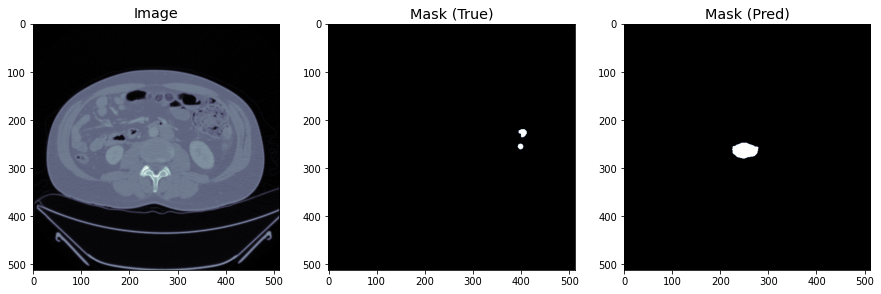

8/8 [==============================] - 0s 7ms/step


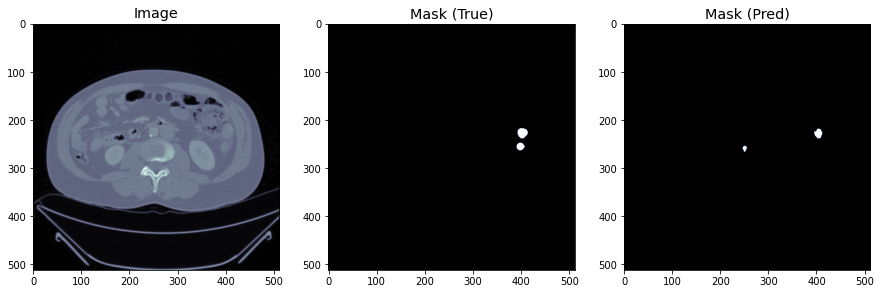

8/8 [==============================] - 0s 9ms/step


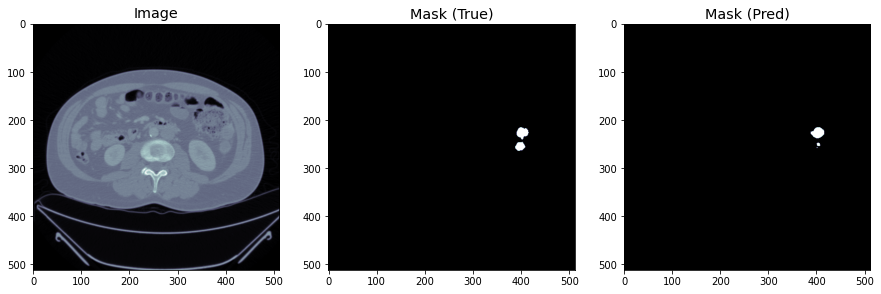

8/8 [==============================] - 0s 8ms/step


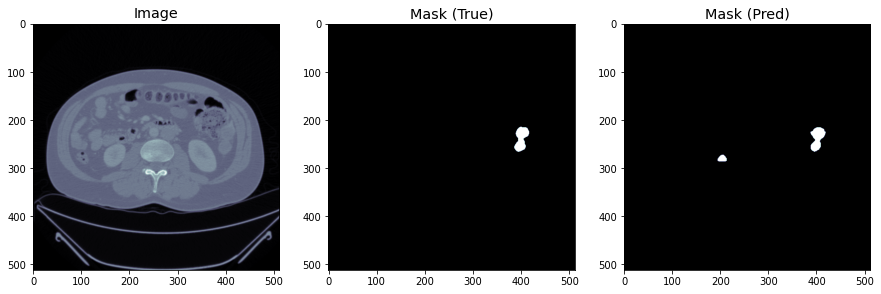

8/8 [==============================] - 0s 8ms/step


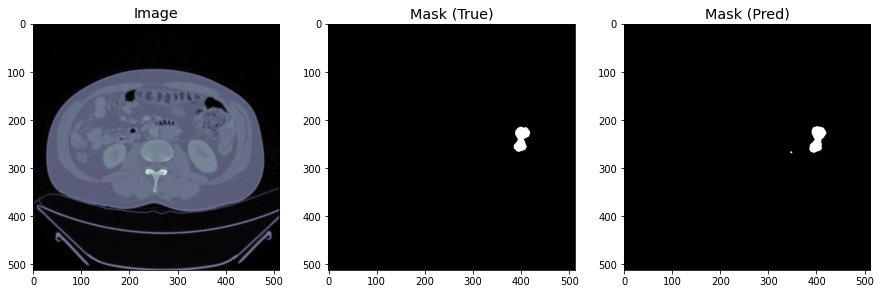

8/8 [==============================] - 0s 8ms/step


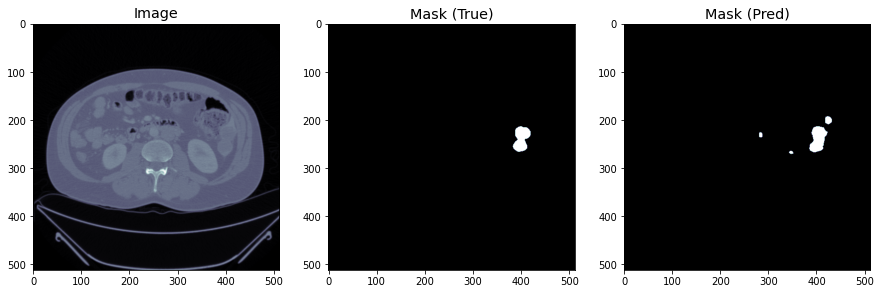

8/8 [==============================] - 0s 7ms/step


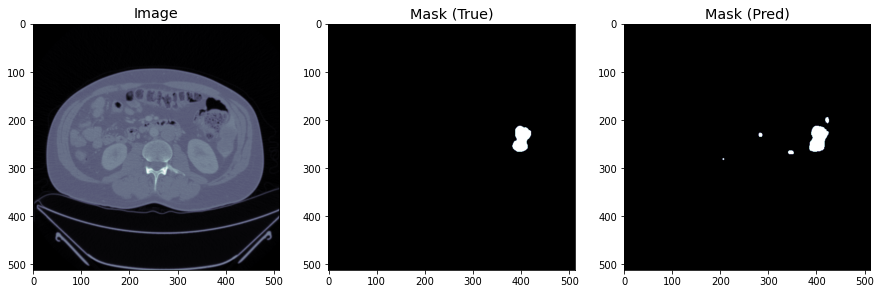

8/8 [==============================] - 0s 11ms/step


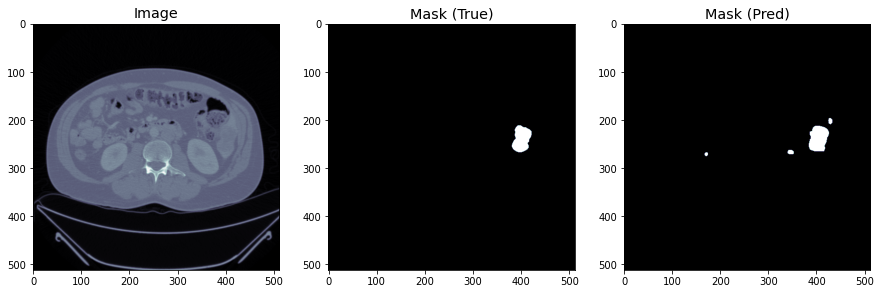

8/8 [==============================] - 0s 7ms/step


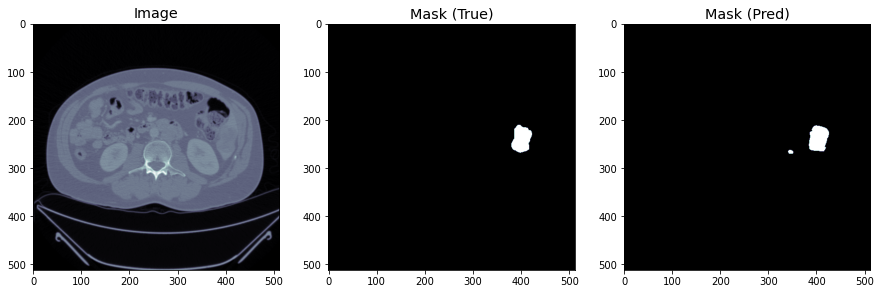

8/8 [==============================] - 0s 8ms/step


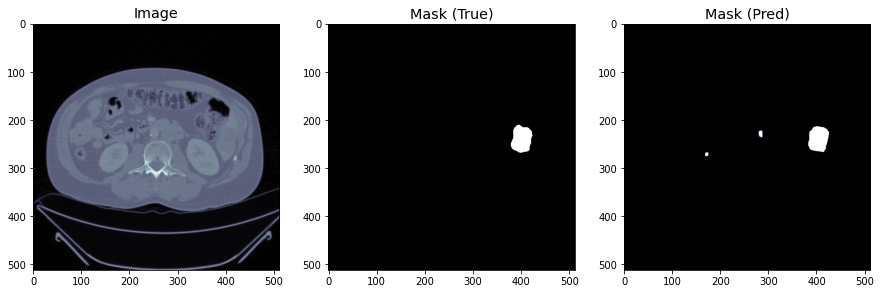

8/8 [==============================] - 0s 8ms/step


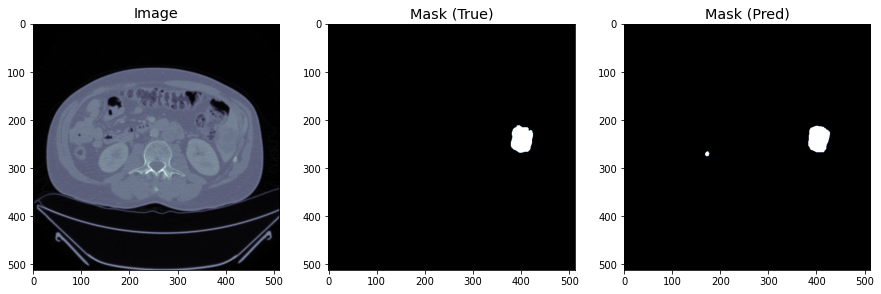

8/8 [==============================] - 0s 7ms/step


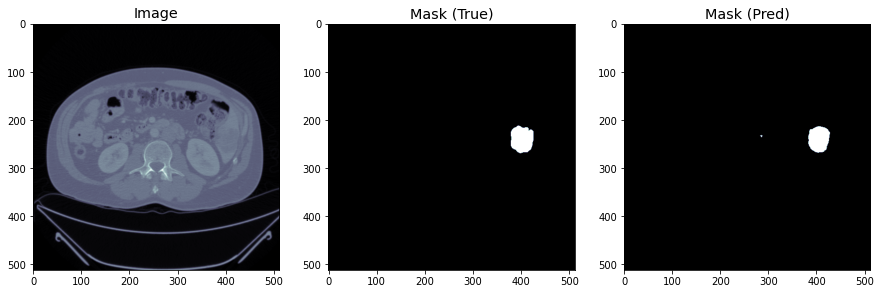

8/8 [==============================] - 0s 7ms/step


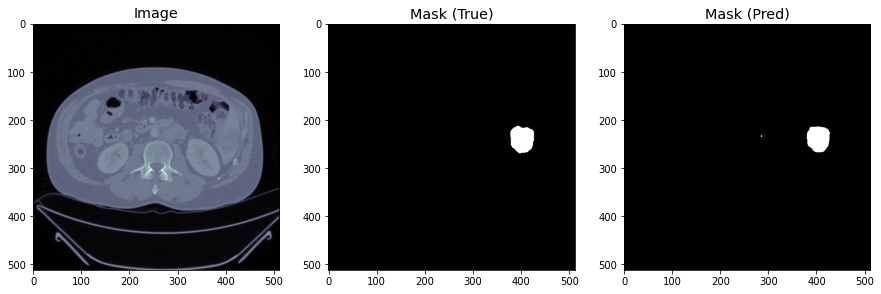

8/8 [==============================] - 0s 8ms/step


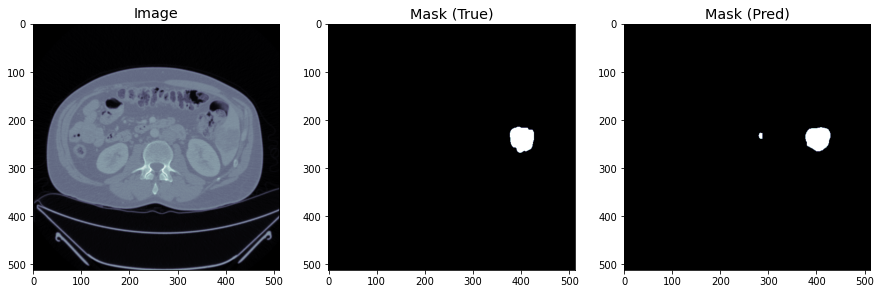

8/8 [==============================] - 0s 7ms/step


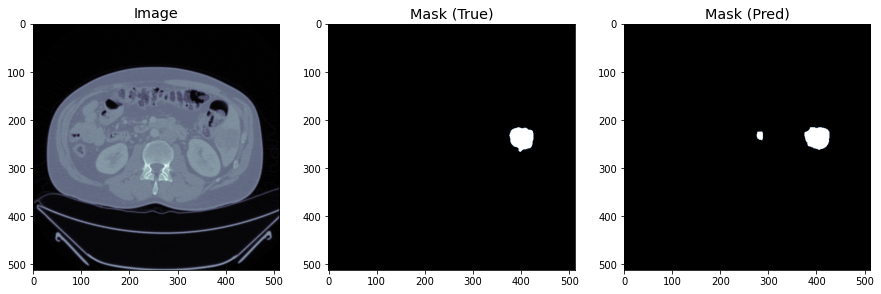

8/8 [==============================] - 0s 7ms/step


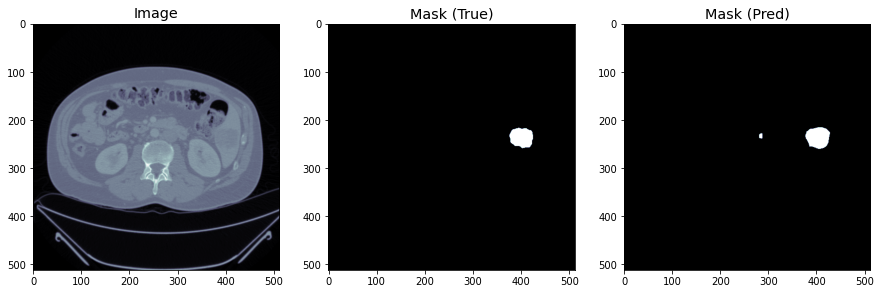

8/8 [==============================] - 0s 12ms/step


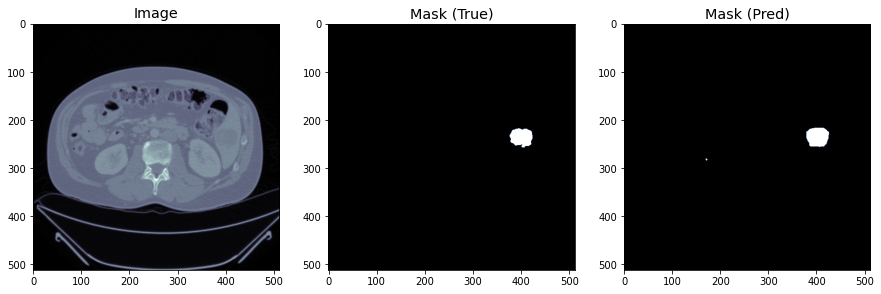

8/8 [==============================] - 0s 7ms/step


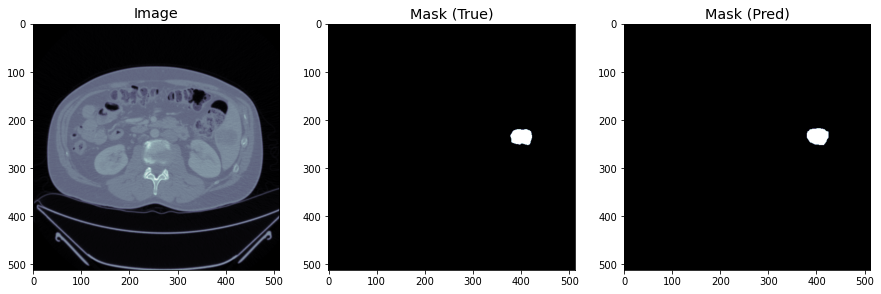

8/8 [==============================] - 0s 11ms/step


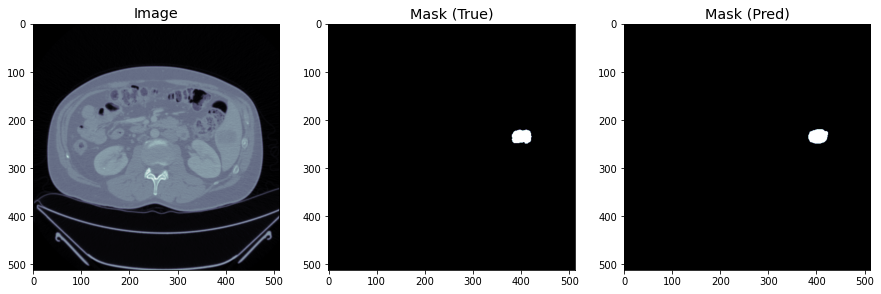

8/8 [==============================] - 0s 7ms/step


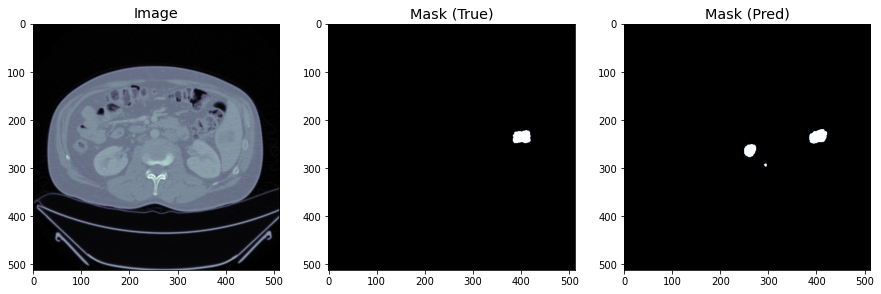

8/8 [==============================] - 0s 7ms/step


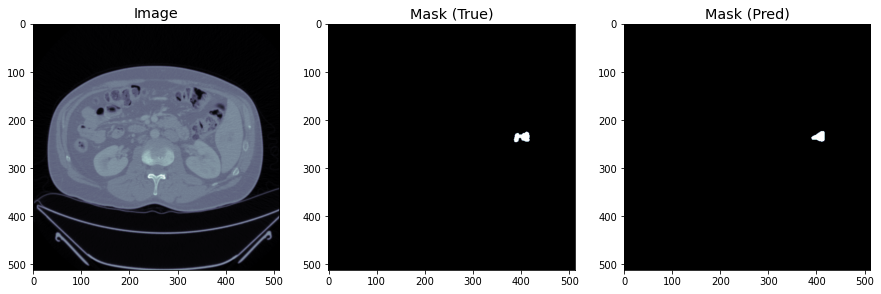

8/8 [==============================] - 0s 10ms/step


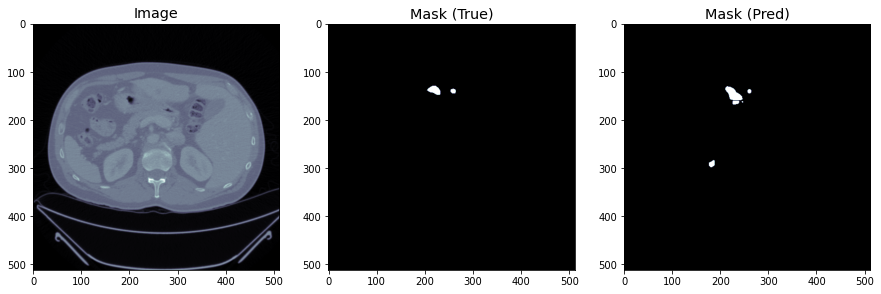

8/8 [==============================] - 0s 7ms/step


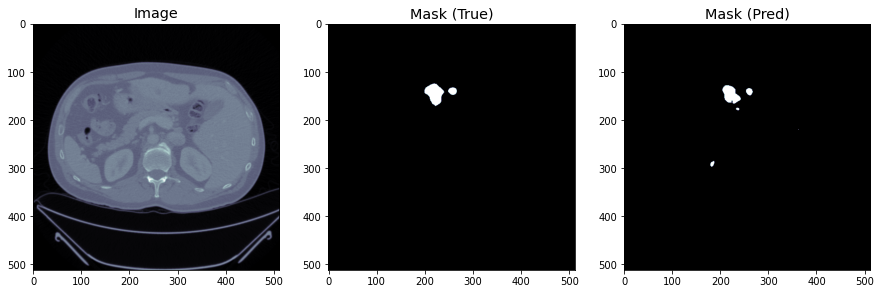

8/8 [==============================] - 0s 7ms/step


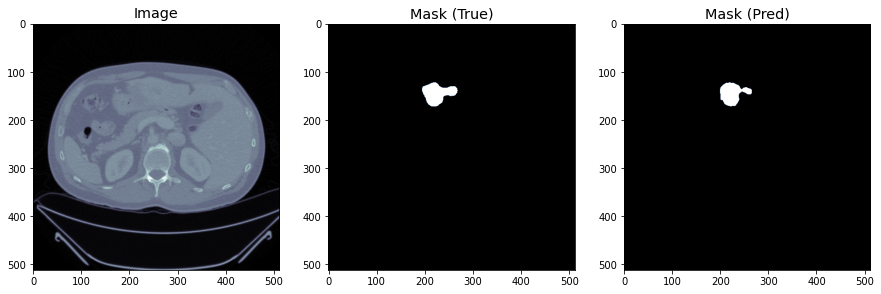

8/8 [==============================] - 0s 8ms/step


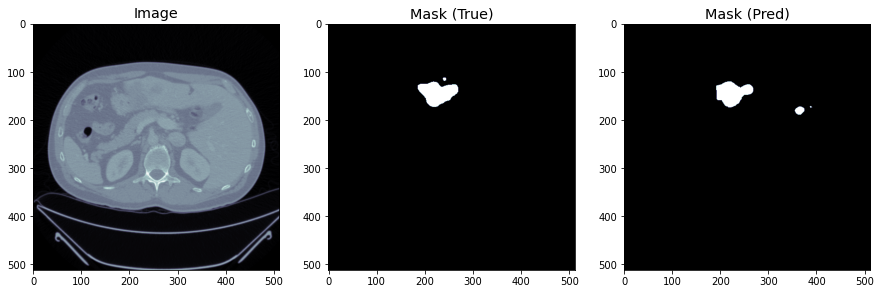

8/8 [==============================] - 0s 8ms/step


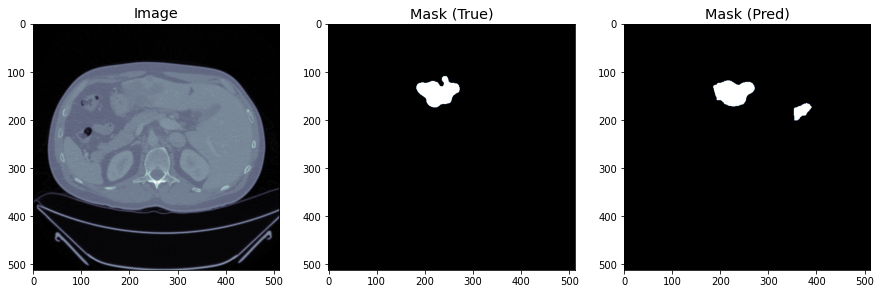

8/8 [==============================] - 0s 7ms/step


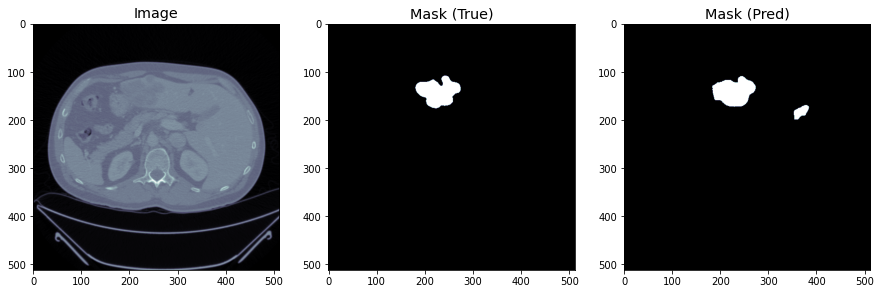

8/8 [==============================] - 0s 7ms/step


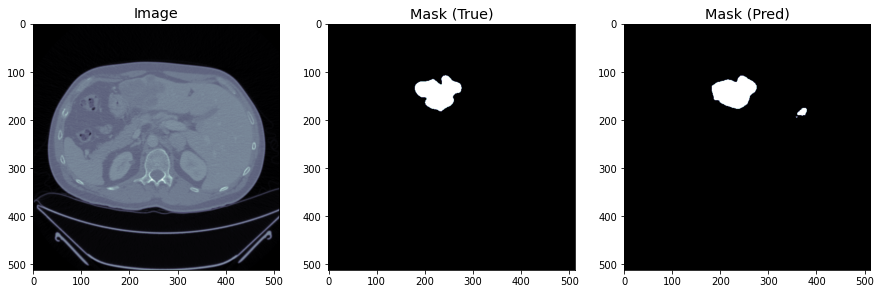

8/8 [==============================] - 0s 7ms/step


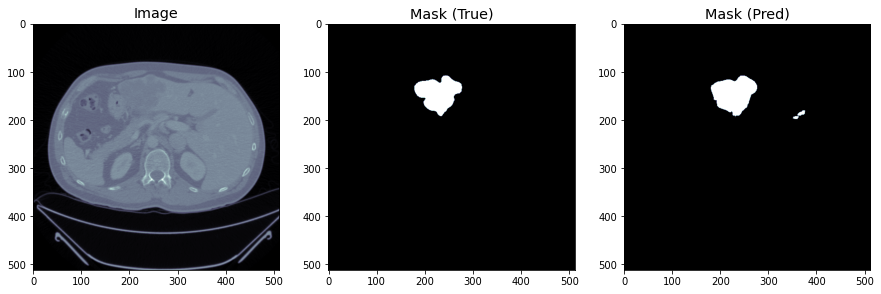

8/8 [==============================] - 0s 8ms/step


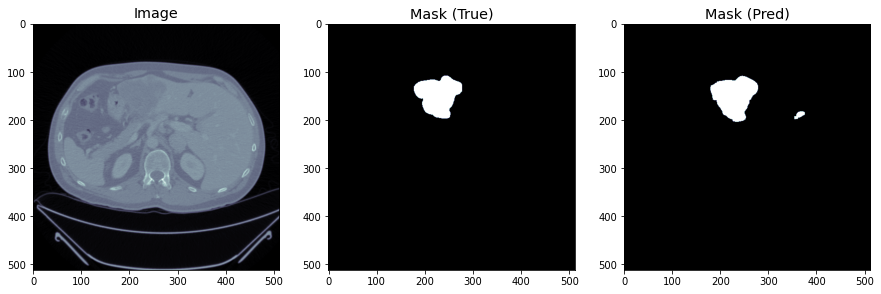

8/8 [==============================] - 0s 10ms/step


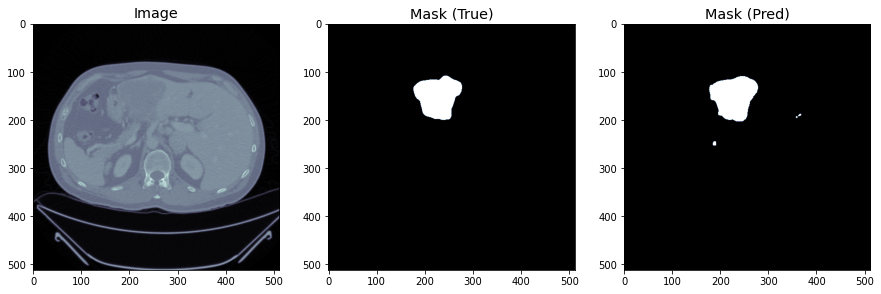

8/8 [==============================] - 0s 7ms/step


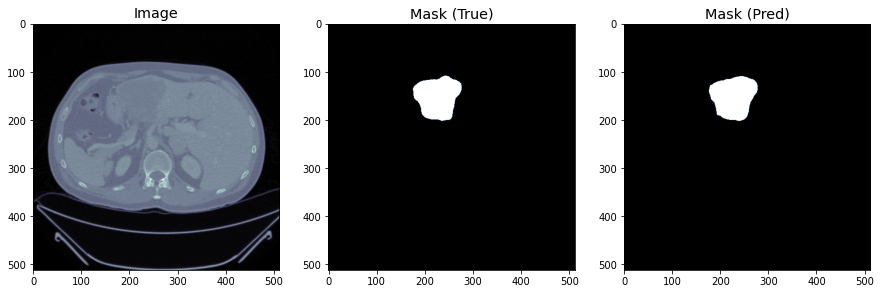

8/8 [==============================] - 0s 7ms/step


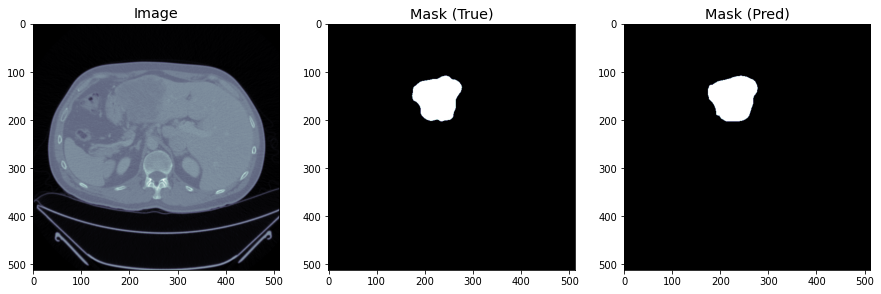

8/8 [==============================] - 0s 19ms/step


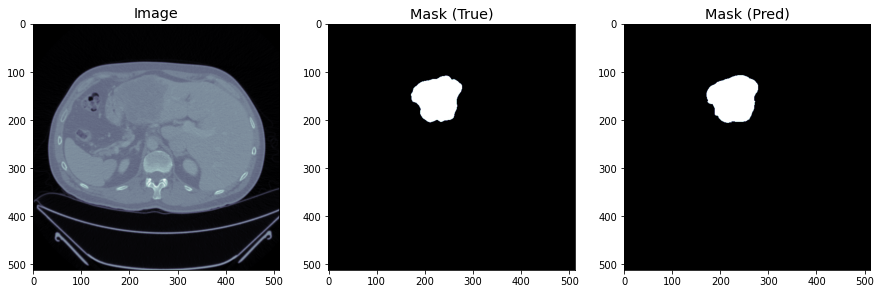

8/8 [==============================] - 0s 9ms/step


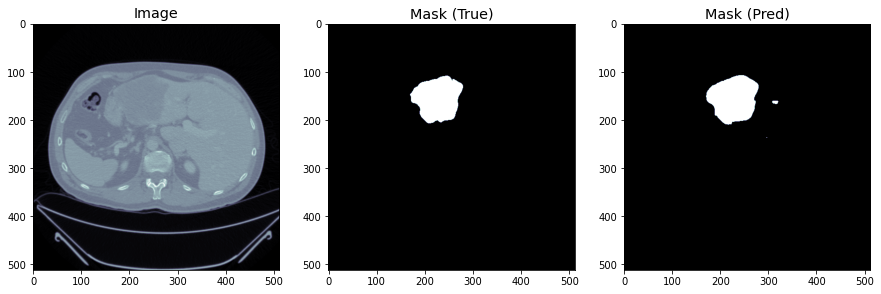

8/8 [==============================] - 0s 8ms/step


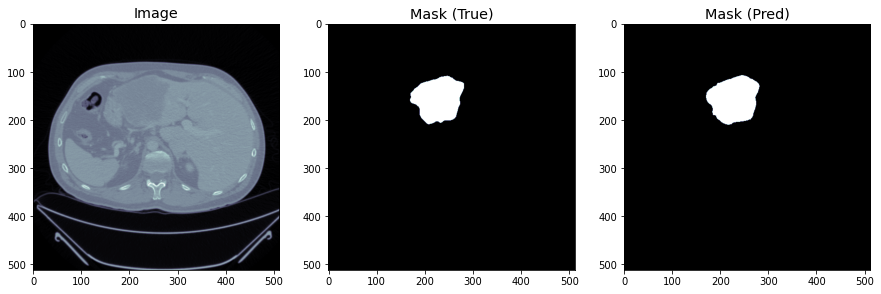

8/8 [==============================] - 0s 9ms/step


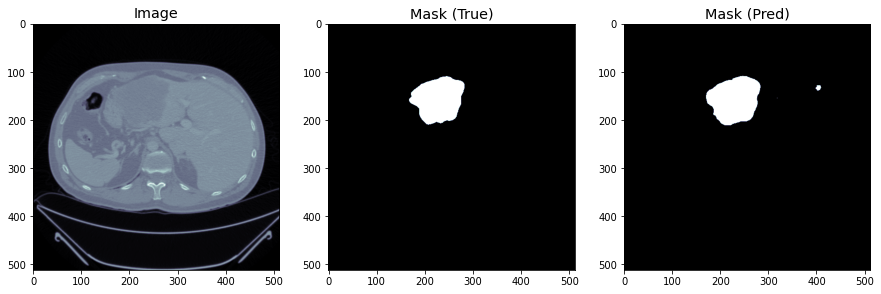

8/8 [==============================] - 0s 10ms/step


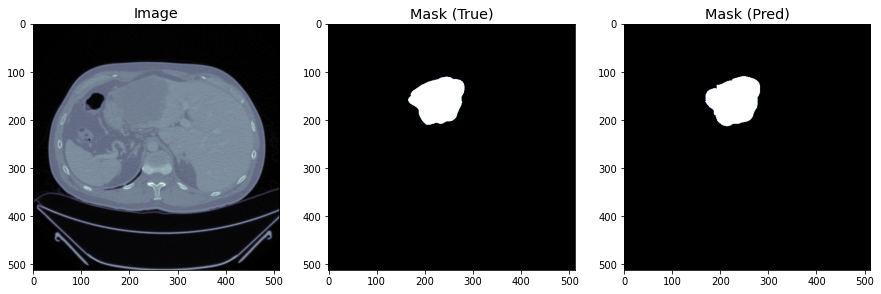

8/8 [==============================] - 0s 7ms/step


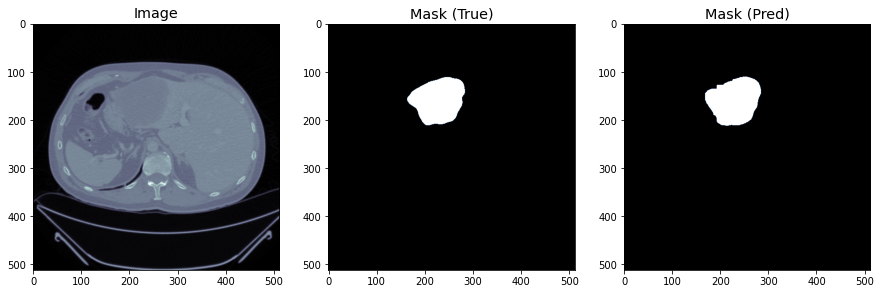

8/8 [==============================] - 0s 13ms/step


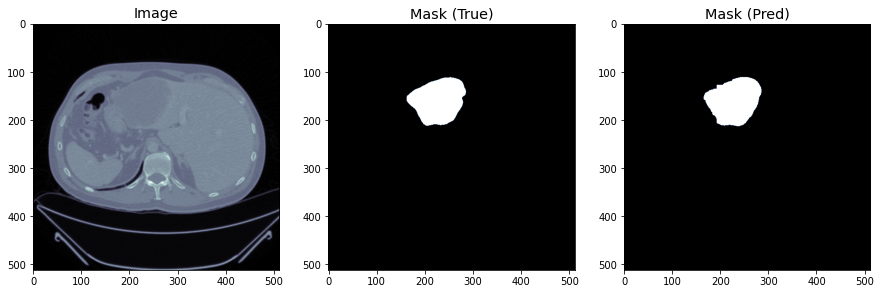

8/8 [==============================] - 0s 10ms/step


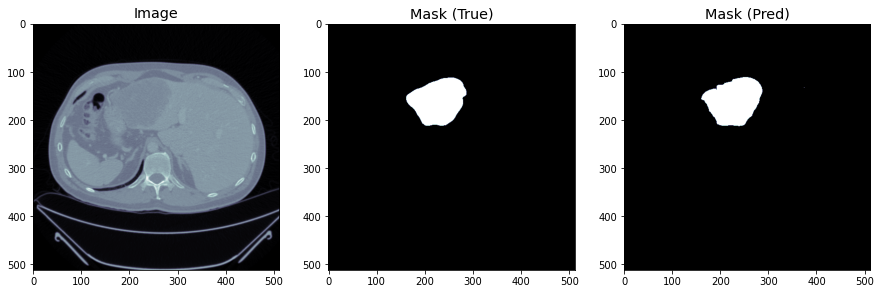

8/8 [==============================] - 0s 8ms/step


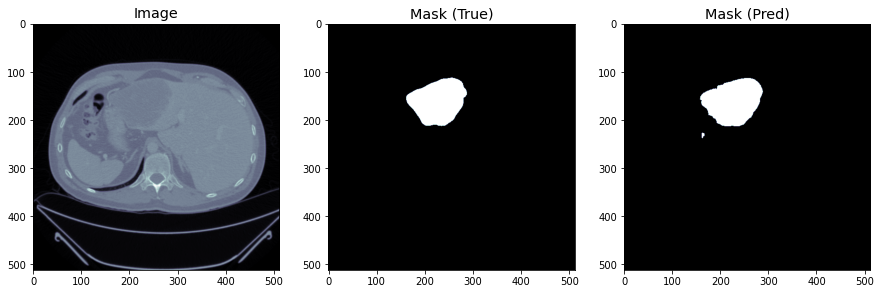

8/8 [==============================] - 0s 12ms/step


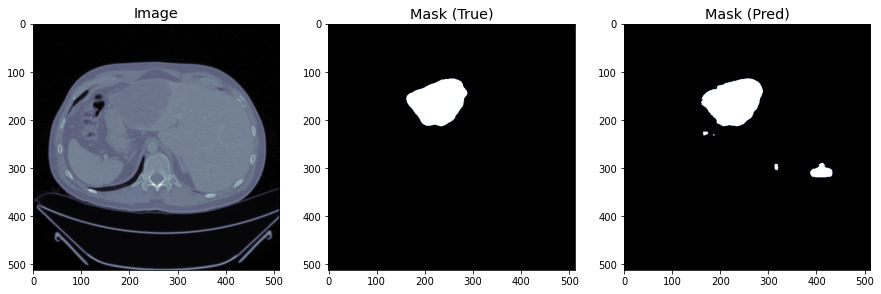

8/8 [==============================] - 0s 9ms/step


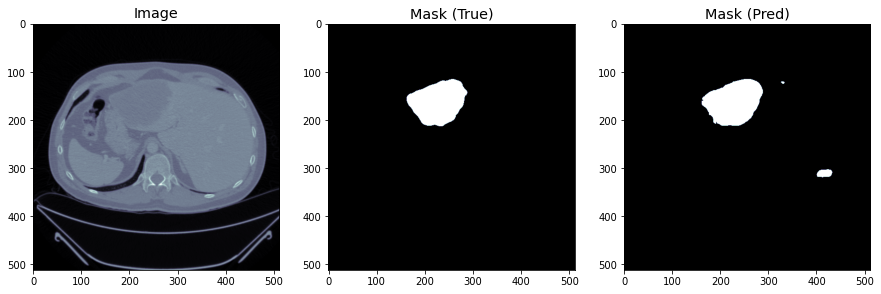

8/8 [==============================] - 0s 9ms/step


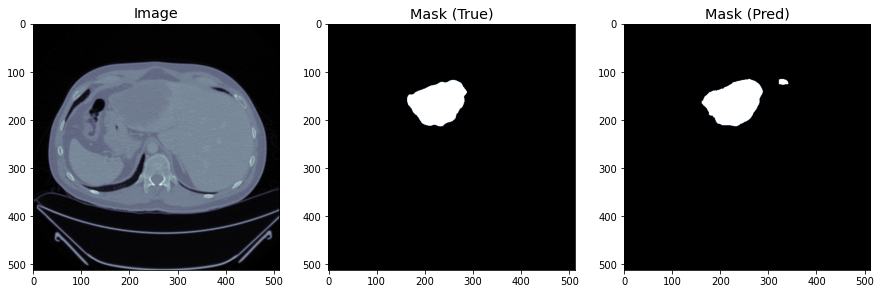

8/8 [==============================] - 0s 13ms/step


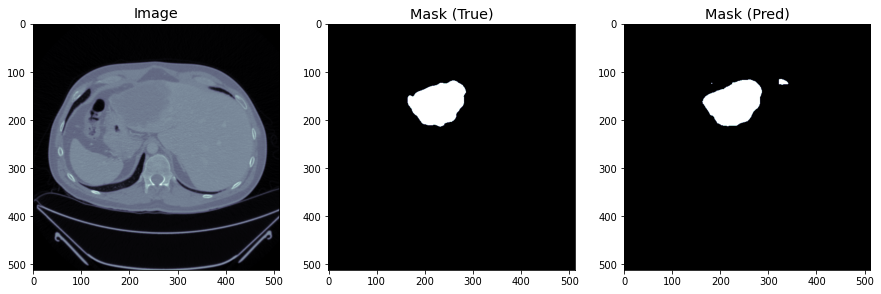

8/8 [==============================] - 0s 10ms/step


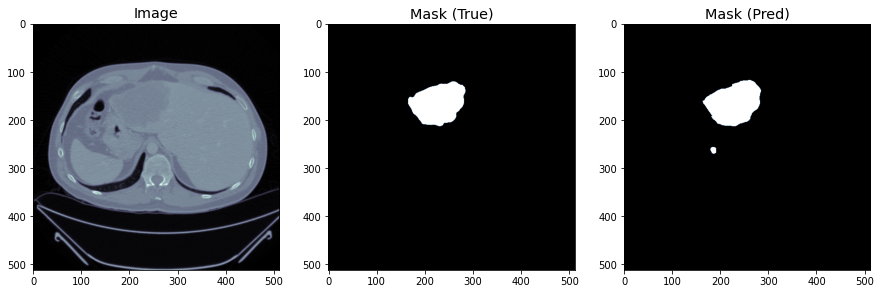

8/8 [==============================] - 0s 9ms/step


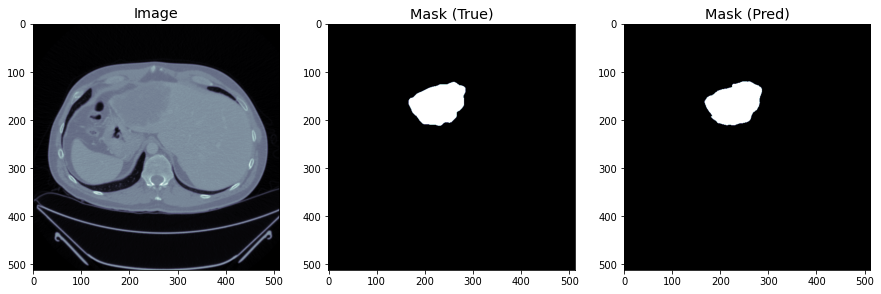

8/8 [==============================] - 0s 12ms/step


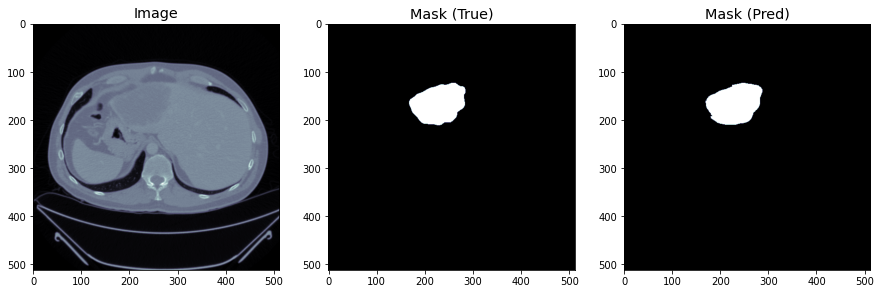

8/8 [==============================] - 0s 10ms/step


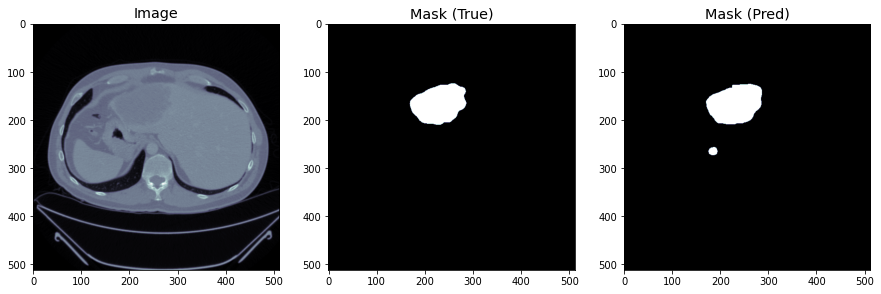

8/8 [==============================] - 0s 7ms/step


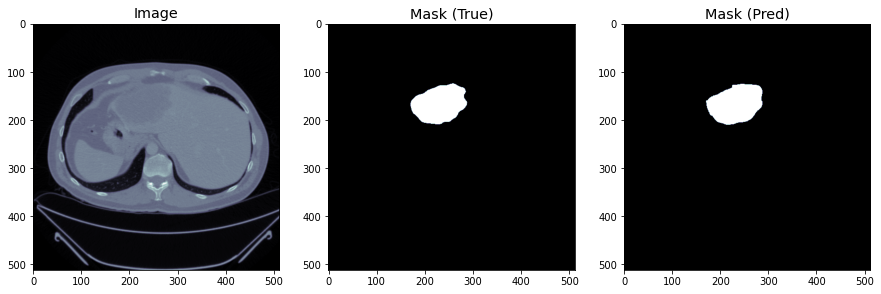

8/8 [==============================] - 0s 10ms/step


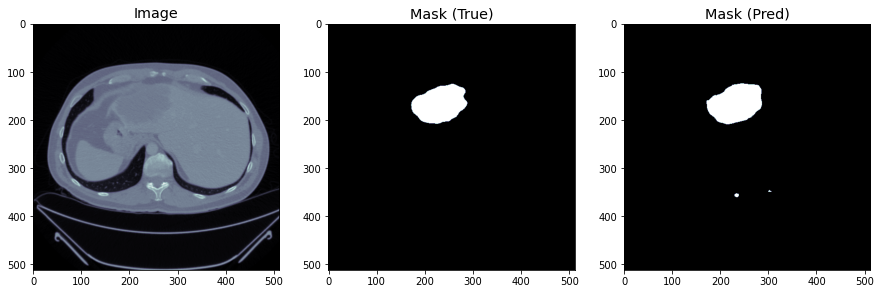

8/8 [==============================] - 0s 14ms/step


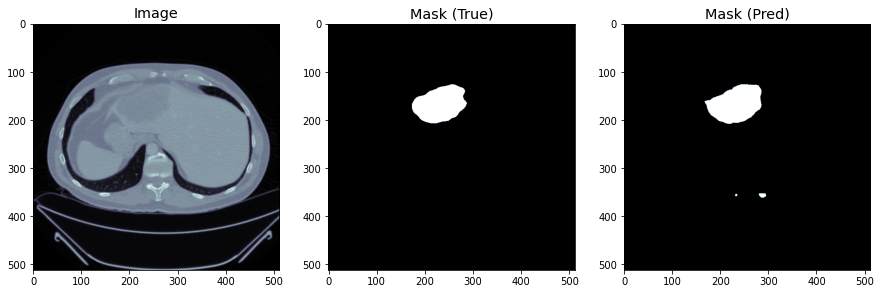

8/8 [==============================] - 0s 7ms/step


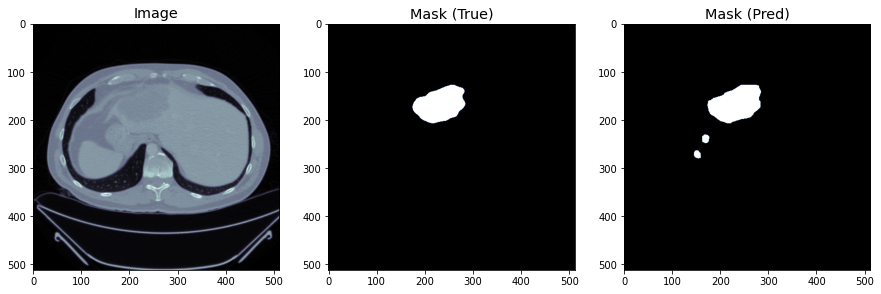

8/8 [==============================] - 0s 8ms/step


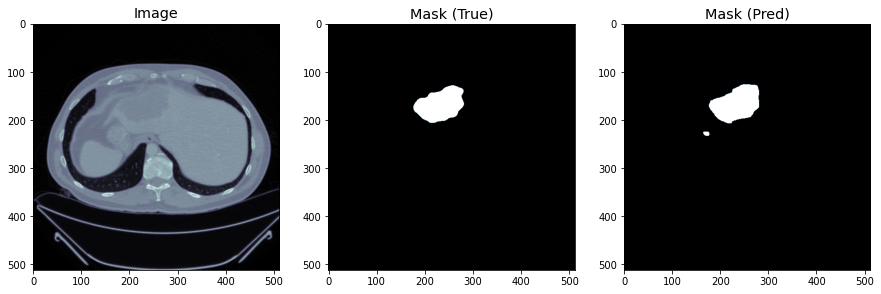

8/8 [==============================] - 0s 14ms/step


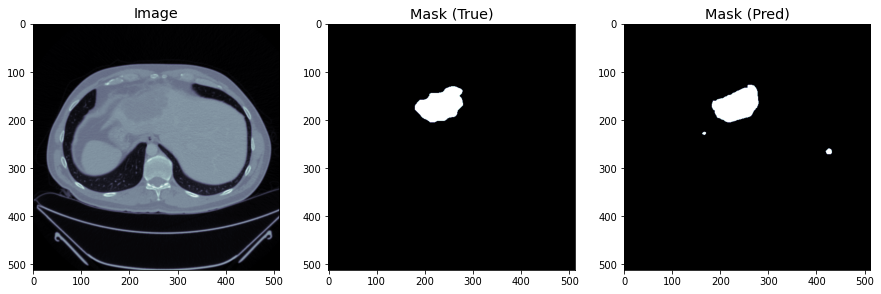

8/8 [==============================] - 0s 13ms/step


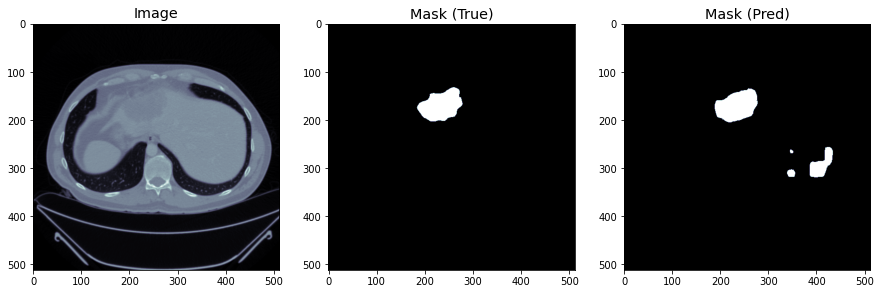

8/8 [==============================] - 0s 11ms/step


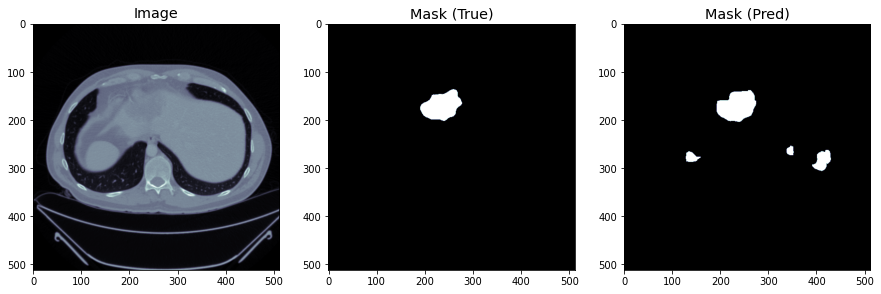

8/8 [==============================] - 0s 11ms/step


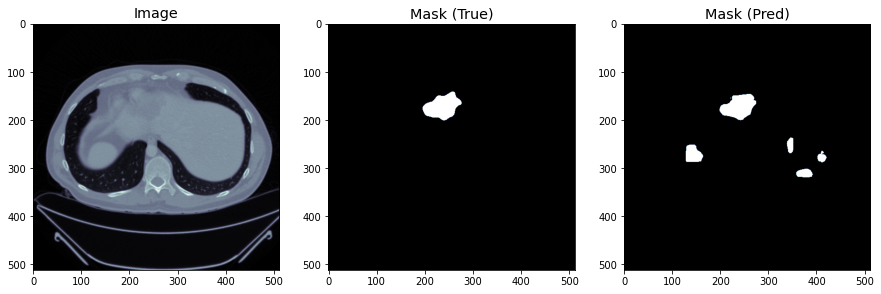

8/8 [==============================] - 0s 11ms/step


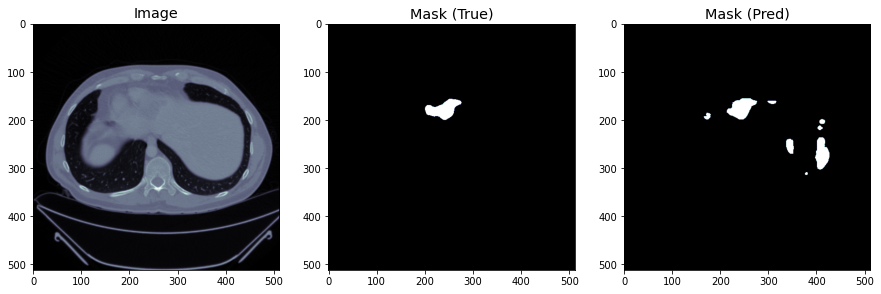

8/8 [==============================] - 0s 10ms/step


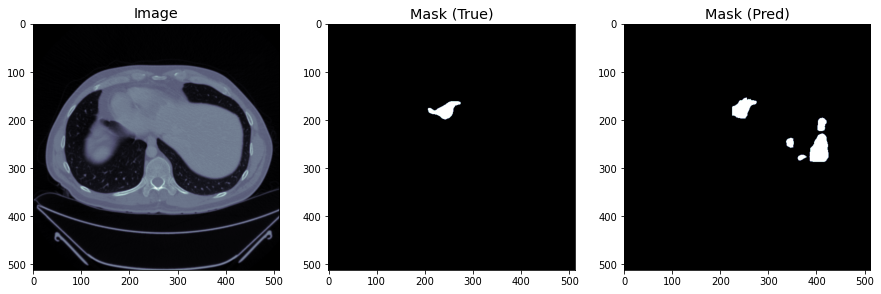

8/8 [==============================] - 0s 14ms/step


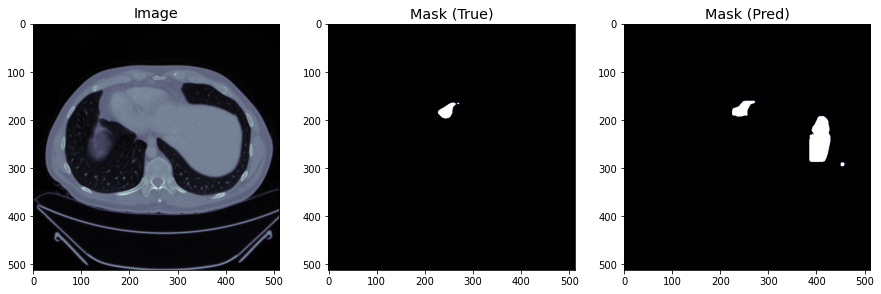

8/8 [==============================] - 0s 8ms/step


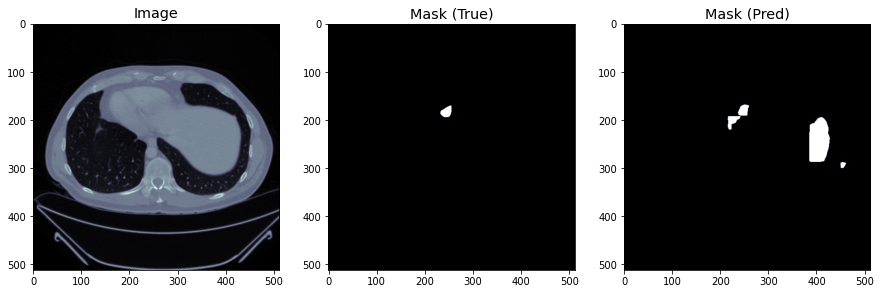

In [30]:
mask_ex[mask_ex == 1] = 0

for i in range(mask_ex.shape[2]):
    _, count = np.unique(mask_ex[:, :, i], return_counts=True)
    
    if len(count) > 1 and count[1] > 300:
        
        patch_ex = slice_to_patch(img_ex[:, :, i], patch_ratio)
        prediction = loaded_model.predict(patch_ex)
        prediction_mask = patch_to_slice(prediction, patch_ratio, input_shape, conf_threshold = 0.97)
        
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize = ((15, 15)))
        
        ax1.imshow(np.rot90(img_ex[:, :, i], 3), cmap = 'bone')
        ax1.set_title("Image", fontsize = "x-large")
        ax1.grid(False)
        ax2.imshow(np.rot90(mask_ex[:, :, i], 3), cmap = 'bone')
        ax2.set_title("Mask (True)", fontsize = "x-large")
        ax2.grid(False)
        ax3.imshow(np.rot90(prediction_mask.reshape((512, 512)), 3), cmap = 'bone')
        ax3.set_title("Mask (Pred)", fontsize = "x-large")
        ax3.grid(False)
        plt.show()